In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import glob
import re 
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
xml_files = sorted(glob.glob("xml data/*.xml"))

In [3]:
#To obtain all the coefficients of the bin to energy convnersion, obtain from just the first XML as I am not changing the calibration 
tree = ET.parse(xml_files[0])
root = tree.getroot()
coefficients = [float(c.text) for c in root.findall(".//EnergyCalibration/Coefficients/Coefficient")]

#generate the Array for energy vales/ X-axis array(energies), in KeV
bins=np.arange(1024)
energies = np.round(coefficients[0]+coefficients[1]*bins+coefficients[2]*bins**2,1)
numFiles=len(xml_files)

In [21]:
#initializing arrays
all_spectra = np.zeros((1024, numFiles))
countPMinute = np.zeros((1024, numFiles))
metadata = np.empty((9,numFiles),dtype=object)

In [22]:
#loop to get information and put them in each array as needed
for i, xml_file in enumerate(xml_files):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    #loops for all occurances of data point gets the number, adds it to each row of all_spectra
    all_spectra[:, i] = [int(dp.text) for dp in root.findall(".//EnergySpectrum/Spectrum/DataPoint")]
    measurement_time = float(root.find(".//MeasurementTime").text)
    fileName = root.find(".//SampleInfo/Name").text
    
    note_text = root.find(".//Note").text
    match = re.search(r"Temp:(\d+),La:([\d.-]+),Lo:([\d.-]+),Area:(\w+),Battery:(\d+)-(\d+),Weather:(\w+)", note_text)
    
    metadata[0,i] = match.group(1)
    metadata[1,i] = match.group(2)
    metadata[2,i] = match.group(3)
    metadata[3,i] = match.group(4)
    metadata[4,i] = match.group(5) +"-"+ match.group(6)
    metadata[5,i] = match.group(7)
    metadata[6,i] = measurement_time
    metadata[7,i] = fileName

    if "Urban" in metadata[7,i]:
        colour = 'k'
    elif "Coast" in metadata[7,i]:
        colour ='r'
    elif "Countryside" in str(metadata[7,i]):
        colour = 'b'
    else:
        colour = 'g'
    

    
    metadata[8,i] = colour

In [23]:
#convert data for counts per minute
for i in range(numFiles):
    countPMinute[:,i] = ((all_spectra[:,i])*60)/metadata[6,i]

#removes 0's for log stuff
nonZeroCountPMinute = np.zeros((1024, numFiles))
for i in range(numFiles):
    for j in range(1024):
        if countPMinute[j,i] < 1e-10:
            nonZeroCountPMinute[j,i] = 1e-2
        else:
            nonZeroCountPMinute[j,i] = countPMinute[j,i] 

In [33]:
for i in range(8):
    print(metadata[i:5])

[['13' '12' '13' '17' '16' '18' '23' '18' '22' '20']
 ['51.485964' '51.485964' '51.485964' '51.485964' '51.485964' '51.485964'
  '51.466684' '51.466684' '51.220225' '51.466684']
 ['-3.166248' '-3.166248' '-3.166248' '-3.166248' '-3.166248' '-3.166248'
  '-3.164277' '-3.164277' '-0.461123' '-3.164277']
 ['City' 'City' 'City' 'City' 'City' 'City' 'Coast' 'City' 'Countryside'
  'City']
 ['88-83' '83-80' '79-77' '77-70' '70-67' '64-56' '56-54' '54-49'
  '101-101' '64-62']]
[['51.485964' '51.485964' '51.485964' '51.485964' '51.485964' '51.485964'
  '51.466684' '51.466684' '51.220225' '51.466684']
 ['-3.166248' '-3.166248' '-3.166248' '-3.166248' '-3.166248' '-3.166248'
  '-3.164277' '-3.164277' '-0.461123' '-3.164277']
 ['City' 'City' 'City' 'City' 'City' 'City' 'Coast' 'City' 'Countryside'
  'City']
 ['88-83' '83-80' '79-77' '77-70' '70-67' '64-56' '56-54' '54-49'
  '101-101' '64-62']]
[['-3.166248' '-3.166248' '-3.166248' '-3.166248' '-3.166248' '-3.166248'
  '-3.164277' '-3.164277' '-0.4

In [31]:
for i in range(numFiles):
    print("Total cps " + str(np.sum((all_spectra[:,i]))/metadata[6,i]))

Total cps 2.7608075488259822
Total cps 2.721749226006192
Total cps 2.7261918115535613
Total cps 2.777345072807315
Total cps 2.744483109828552
Total cps 2.71860064055186
Total cps 2.2496339677891655
Total cps 2.688760626117507
Total cps 5.89417221468463
Total cps 2.6651972097606516


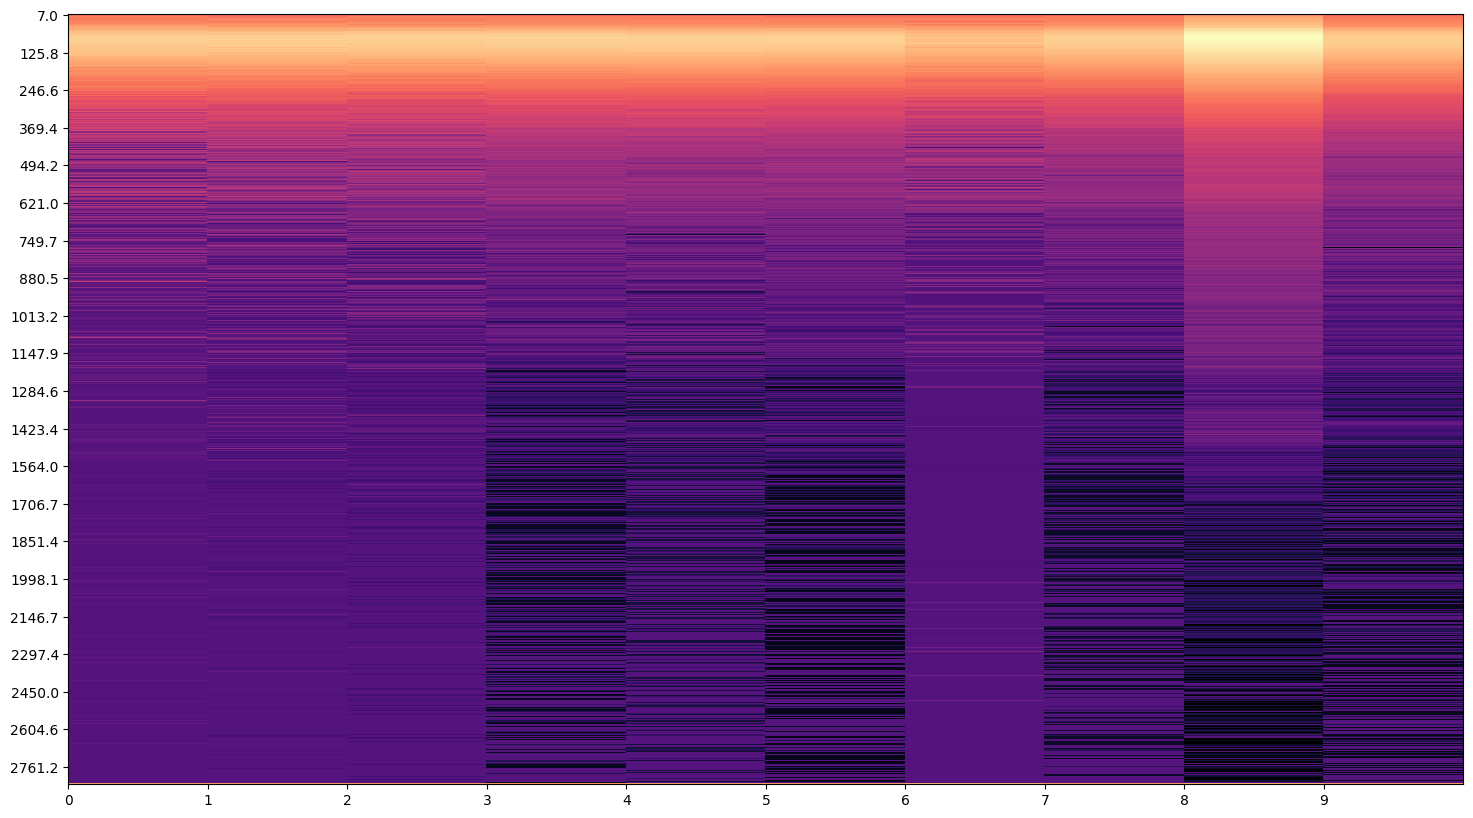

In [30]:
#Image attempt

plt.figure(figsize=(18, 10))
plt.xticks(np.arange(0,countPMinute.shape[1],1))
positions = np.arange(1024)
plt.yticks((positions[::-50]),(energies[::50]))

norm = colors.LogNorm(vmin=np.min(nonZeroCountPMinute), vmax=np.max(nonZeroCountPMinute)) 
plt.imshow(nonZeroCountPMinute, cmap='magma',aspect='auto',extent=[0, countPMinute.shape[1], 0, 1024],interpolation='None',norm=norm)

#plt.savefig('testimages2.png', dpi=150)

In [245]:
'''
#removes 0's
for i in range(numFiles):
    for j in range(1024):
        if countPMinute[j,i] < 1e-10:
            countPMinute[j,i] = None
            '''

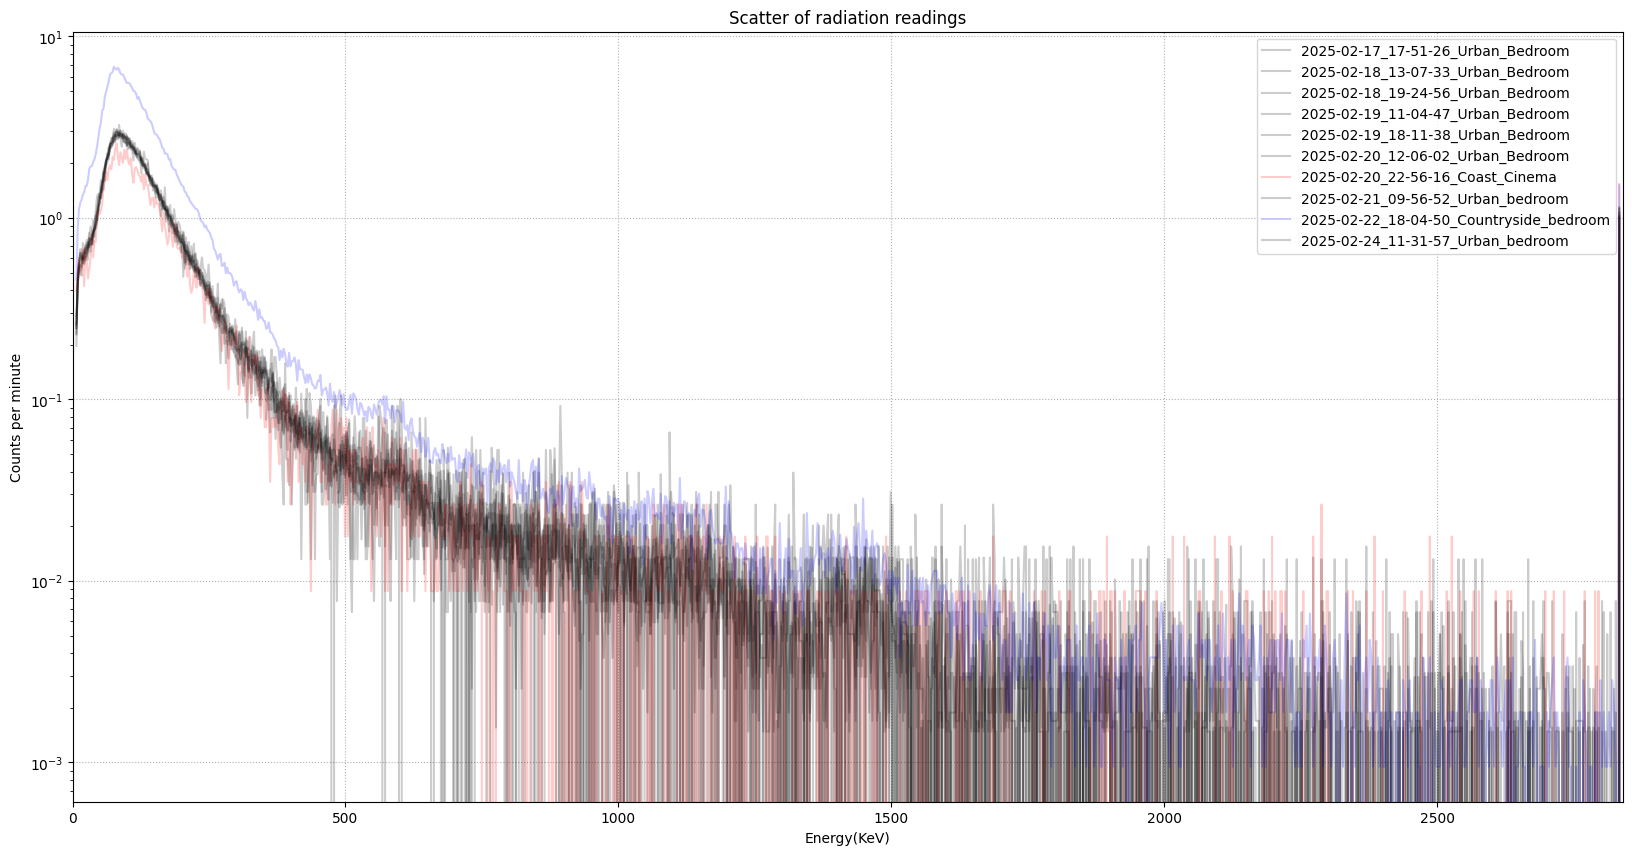

In [28]:
plt.figure(figsize=(20, 10))
plt.xlabel("Energy(KeV)")
plt.ylabel("Counts per minute")
#plt.yscale('log')
plt.xlim(0,2840)
for i in range(numFiles):
    plt.semilogy(energies, countPMinute[:,i],metadata[8,i], alpha=0.2,label=metadata[7,i])

#i += 1
#plt.semilogy(energies, countPMinute[:,i],'r', alpha=0.2,label=metadata[7,i])
    
plt.title("Scatter of radiation readings")
plt.legend(fontsize=10)
plt.grid(ls=":")
#plt.xticks(np.arange(875, 900, step=1))

#plt.savefig('testimages.png', dpi=300,bbox_inches='tight')
plt.show()

C:\Users\louis\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


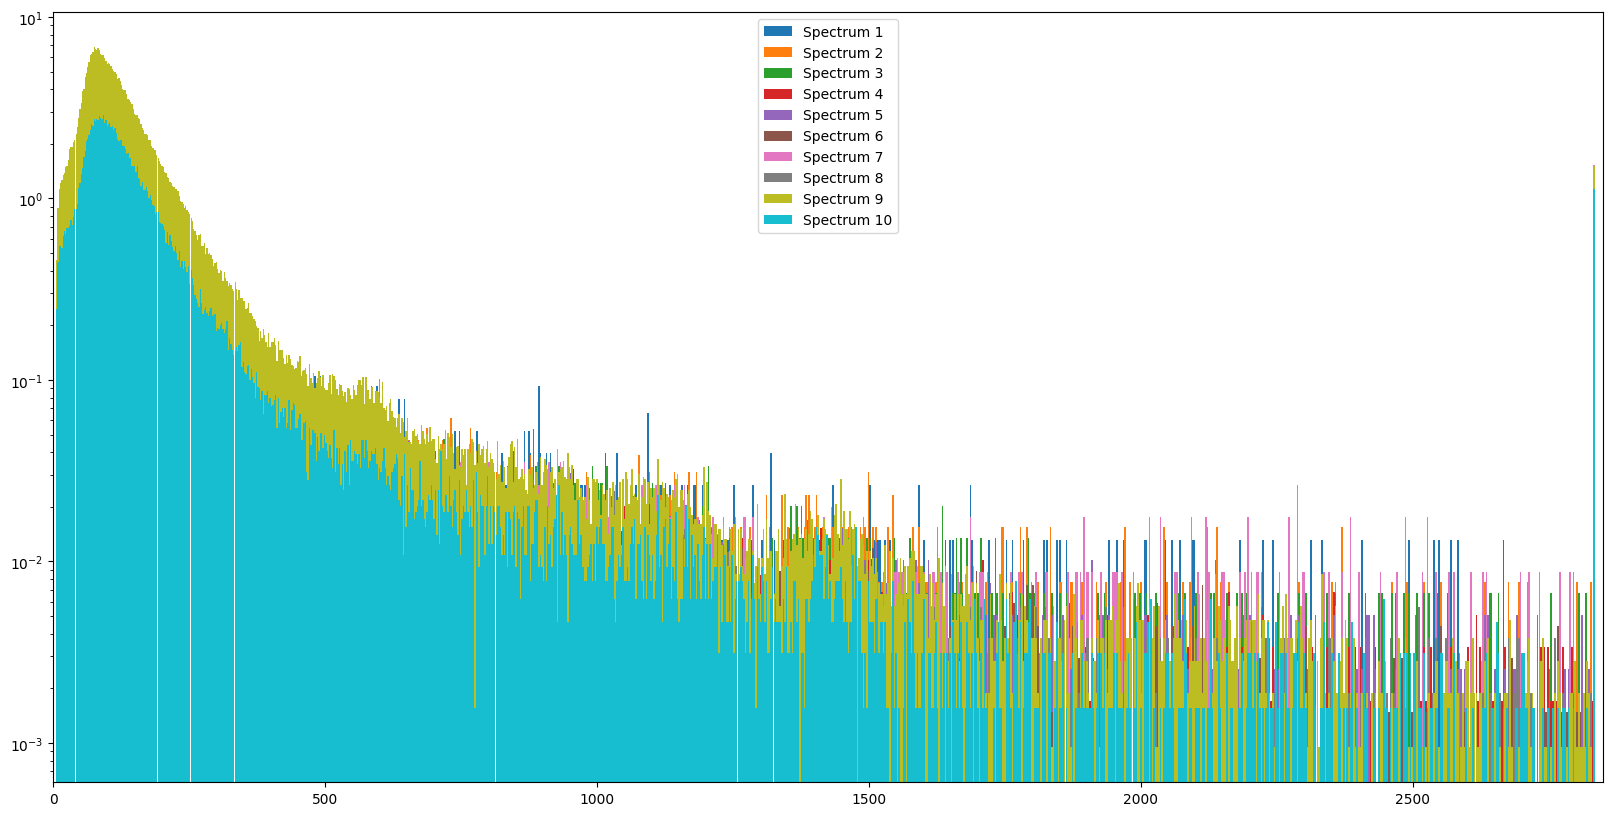

In [26]:

plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.xlim(0,2850)
for i in range(numFiles):
    plt.bar(energies, countPMinute[:,i], label=f'Spectrum {i + 1}', width=np.append(np.diff(energies),np.diff(energies)[-1]))

plt.legend()
plt.show()